In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [15]:
# Load datasets
# Replace these with your actual file paths
median_income_df = pd.read_csv('austinzips_income.csv')
affordable_housing_df = pd.read_csv('affordable_housing.csv')

# Rename the column for consistency
if 'zip' in median_income_df.columns:
    median_income_df = median_income_df.rename(columns={'zip': 'zip_code'})
    print("Renamed 'zip' to 'zip_code' in median_income_df")

Renamed 'zip' to 'zip_code' in median_income_df


In [17]:
# Let's assume we need to aggregate affordable housing counts by zip code
# Count the number of affordable housing units in each zip code
affordable_housing_counts = affordable_housing_df.groupby('zip_code').size().reset_index(name='affordable_housing_count')

In [21]:
# CRITICAL FIX: Convert zip_code to string in BOTH dataframes BEFORE any operations
# This ensures they are the same type when merging
median_income_df['zip_code'] = median_income_df['zip_code'].astype(str)
affordable_housing_df['zip_code'] = affordable_housing_df['zip_code'].astype(str)

# Verify the data types after conversion
print("\nAfter type conversion:")
print("Median income zip_code type:", median_income_df['zip_code'].dtype)
print("Affordable housing zip_code type:", affordable_housing_df['zip_code'].dtype)



After type conversion:
Median income zip_code type: object
Affordable housing zip_code type: object


In [22]:
# Count the number of affordable housing units in each zip code
affordable_housing_counts = affordable_housing_df.groupby('zip_code').size().reset_index(name='affordable_housing_count')

In [23]:
# The zip_code in the grouped dataframe might need to be converted again
affordable_housing_counts['zip_code'] = affordable_housing_counts['zip_code'].astype(str)

In [24]:
# Now try the merge with both columns as string type
try:
    merged_df = pd.merge(median_income_df, affordable_housing_counts, on='zip_code', how='left')
    print("\nMerge successful!")
except Exception as e:
    print(f"\nMerge failed with error: {e}")
    
    # Alternative approach using direct concatenation
    print("\nTrying alternative approach with concat...")
    # First, set the index to zip_code for both dataframes
    median_income_indexed = median_income_df.set_index('zip_code')
    affordable_housing_counts_indexed = affordable_housing_counts.set_index('zip_code')
    
    # Then concatenate horizontally
    merged_df = pd.concat([median_income_indexed, affordable_housing_counts_indexed], axis=1)
    
    # Reset index to make zip_code a column again
    merged_df = merged_df.reset_index()
    print("Alternative approach successful!")


Merge successful!


In [25]:
# Fill NaN values with 0 (zip codes with no affordable housing)
if 'affordable_housing_count' in merged_df.columns:
    merged_df['affordable_housing_count'].fillna(0, inplace=True)
else:
    print("Warning: 'affordable_housing_count' column not found in merged dataframe")
    print("Available columns:", merged_df.columns.tolist())

In [26]:
# Print first few rows of the merged dataframe to verify
print("\nMerged dataframe preview:")
print(merged_df.head())


Merged dataframe preview:
  zip_code       lat       lng    city state_id state_name  zcta  population  \
0    78701  30.27022 -97.74248  Austin       TX      Texas  True       11114   
1    78702  30.26339 -97.71440  Austin       TX      Texas  True       26495   
2    78703  30.29385 -97.76554  Austin       TX      Texas  True       22484   
3    78704  30.24298 -97.76537  Austin       TX      Texas  True       50479   
4    78705  30.29470 -97.73900  Austin       TX      Texas  True       32937   

   density county_name county_names_all county_fips_all  \
0   2845.1      Travis           Travis           48453   
1   2043.5      Travis           Travis           48453   
2   1544.0      Travis           Travis           48453   
3   2223.8      Travis           Travis           48453   
4   6143.4      Travis           Travis           48453   

   income_household_median  affordable_housing_count  
0                 154867.0                      10.0  
1                 101304.0 

In [28]:
# Check if 'median_income' column exists in the merged dataframe
if 'income_household_median' not in merged_df.columns:
    print("Warning: 'income_household_median' column not found in merged dataframe")
    # Try to identify the median income column by looking for columns with numeric data
    numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()
    print("Available numeric columns:", numeric_columns)
    if numeric_columns:
        potential_income_col = numeric_columns[0]  # Use the first numeric column as a guess
        print(f"Using '{potential_income_col}' as median income column")
        merged_df['income_household_median'] = merged_df[potential_income_col]

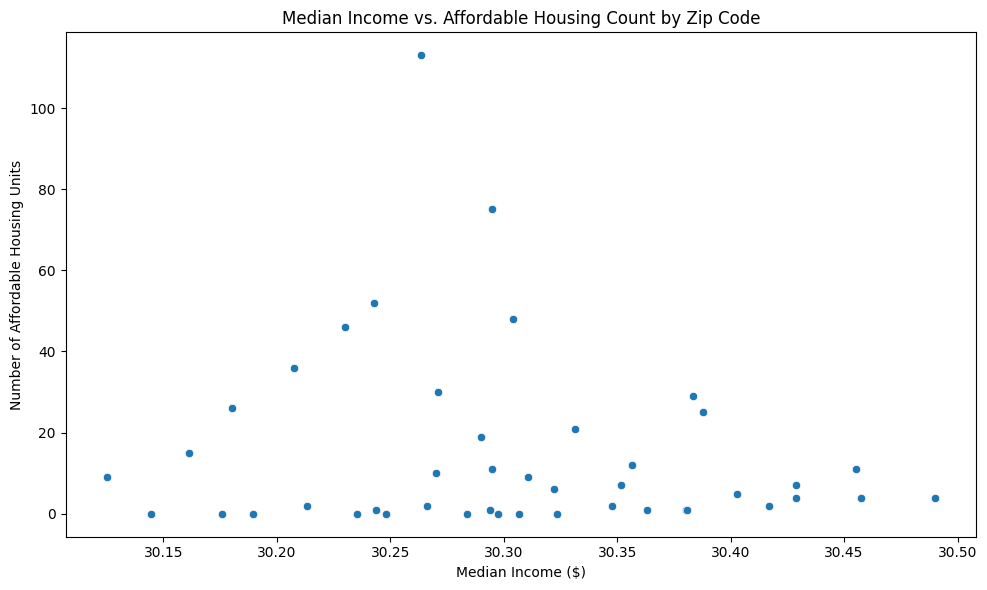

In [29]:
# Check if both required columns exist before proceeding
if 'income_household_median' in merged_df.columns and 'affordable_housing_count' in merged_df.columns:
    # Let's explore the relationship between median income and affordable housing count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='median_income', y='affordable_housing_count', data=merged_df)
    plt.title('Median Income vs. Affordable Housing Count by Zip Code')
    plt.xlabel('Median Income ($)')
    plt.ylabel('Number of Affordable Housing Units')
    plt.tight_layout()
    plt.savefig('income_vs_housing.png')
    plt.show()

In [31]:
 # Create correlation matrix
    correlation = merged_df['median_income'].corr(merged_df['affordable_housing_count'])
    print(f"\nCorrelation between median income and affordable housing count: {correlation:.2f}")

IndentationError: unexpected indent (438291172.py, line 2)

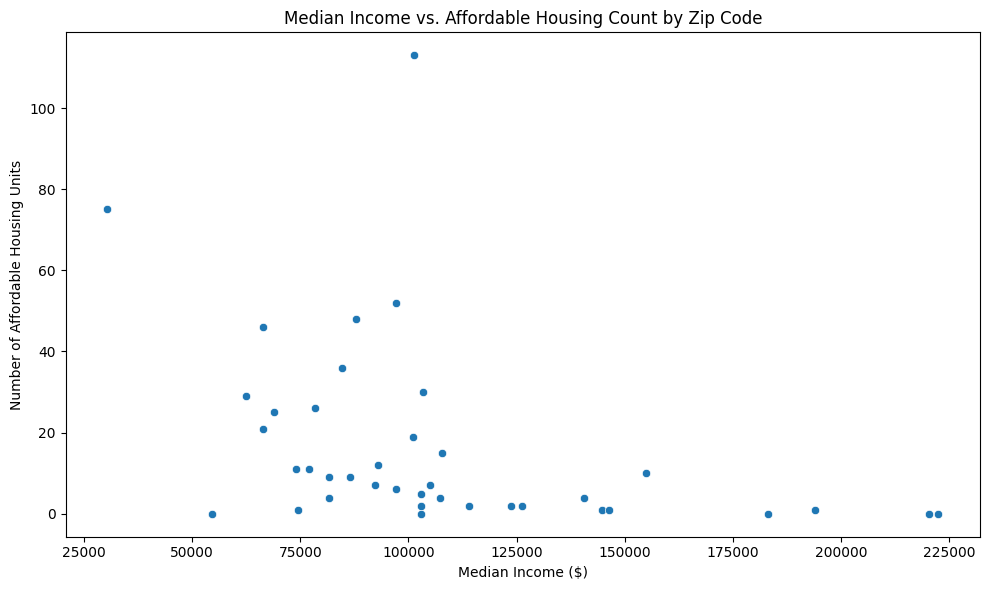


Correlation between median income and affordable housing count: -0.14


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
# Check if both required columns exist before proceeding
if 'income_household_median' in merged_df.columns and 'affordable_housing_count' in merged_df.columns:
    # Let's explore the relationship between median income and affordable housing count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='income_household_median', y='affordable_housing_count', data=merged_df)
    plt.title('Median Income vs. Affordable Housing Count by Zip Code')
    plt.xlabel('Median Income (USD)')
    plt.ylabel('Number of Affordable Housing Units')
    plt.tight_layout()
    plt.savefig('income_vs_housing.png')
    plt.show()

    # Create correlation matrix
    correlation = merged_df['median_income'].corr(merged_df['affordable_housing_count'])
    print(f"\nCorrelation between median income and affordable housing count: {correlation:.2f}")

    # Prepare data for Random Forest
    X = merged_df[['income_household_median']]  # Features
    y = merged_df['affordable_housing_count']  # Target

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = rf.predict(X_test_scaled)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Evaluation:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Visualize actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('Actual vs. Predicted Affordable Housing Counts')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.show()

    # Interpret the results
    print("\nInterpretation:")
    if r2 > 0.7:
        print("The model shows a strong relationship between median income and affordable housing distribution.")
    elif r2 > 0.4:
        print("The model shows a moderate relationship between median income and affordable housing distribution.")
    else:
        print("The model shows a weak relationship between median income and affordable housing distribution.")
        print("This suggests that factors other than median income may be driving affordable housing placement decisions.")

    if correlation < 0:
        print("The negative correlation indicates more affordable housing in lower-income areas.")
    else:
        print("The positive correlation indicates more affordable housing in higher-income areas.")

    # Feature importance analysis
    feature_importance = rf.feature_importances_
    print("\nFeature importance:", feature_importance)

    # For more robust feature importance
    perm_importance = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
    print("Permutation importance:", perm_importance.importances_mean)
else:
    print("Cannot proceed with analysis because required columns are missing")

In [37]:
# Add this after loading the data
print("Sample of median income values:")
print(median_income_df['income_household_median'].head(10))
print(f"Min median income: {median_income_df['income_household_median'].min()}")
print(f"Max median income: {median_income_df['income_household_median'].max()}")

Sample of median income values:
0    154867.0
1    101304.0
2    144637.0
3     97160.0
4     30336.0
5         NaN
6    140483.0
7     54545.0
8    103285.0
9    101034.0
Name: income_household_median, dtype: float64
Min median income: 30336.0
Max median income: 222552.0


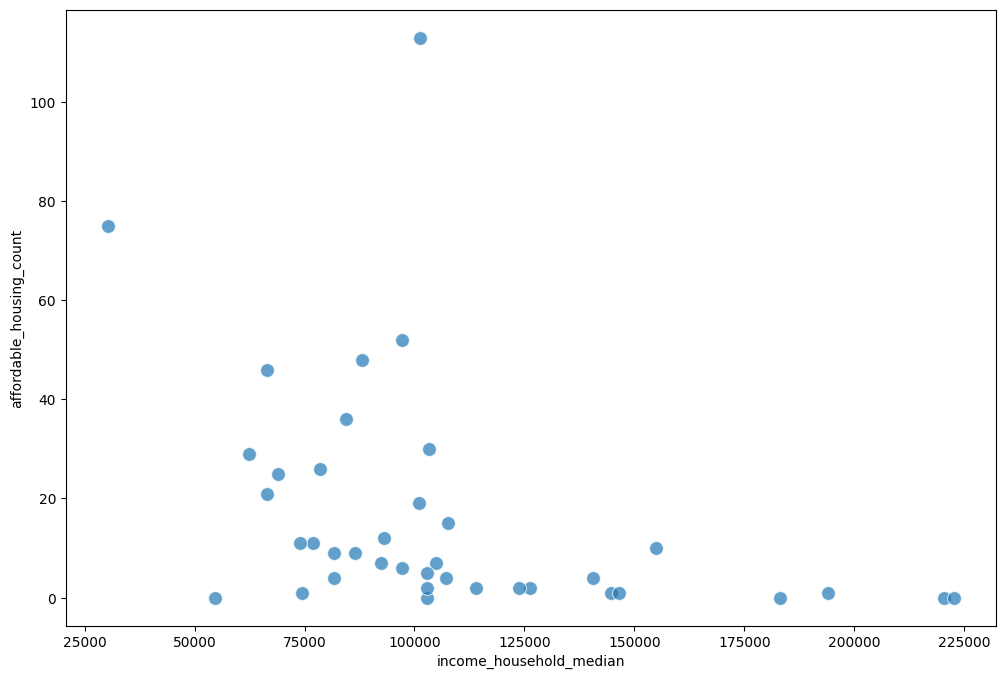

In [39]:
# Create an enhanced visualization that includes zip code information
plt.figure(figsize=(12, 8))

# Create scatter plot
ax = sns.scatterplot(x='income_household_median', y='affordable_housing_count', data=merged_df, s=100, alpha=0.7)

Text(0, 0.5, 'Number of Affordable Housing Units')

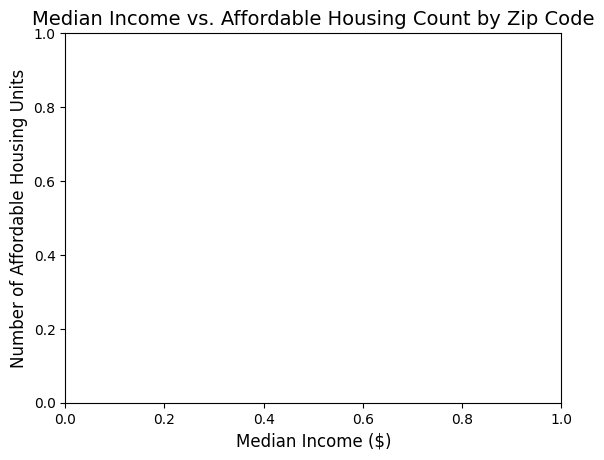

In [41]:
# Add zip code labels to each point
for i, row in merged_df.iterrows():
    plt.annotate(row['zip_code'], 
                 (row['income_household_median'], row['affordable_housing_count']),
                 xytext=(5, 5),  # 5 points offset
                 textcoords='offset points',
                 fontsize=8,
                 alpha=0.8)

plt.title('Median Income vs. Affordable Housing Count by Zip Code', fontsize=14)
plt.xlabel('Median Income ($)', fontsize=12)
plt.ylabel('Number of Affordable Housing Units', fontsize=12)